<a href="https://colab.research.google.com/github/aonori3/reconstruction_mit/blob/main/topology_reconstruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

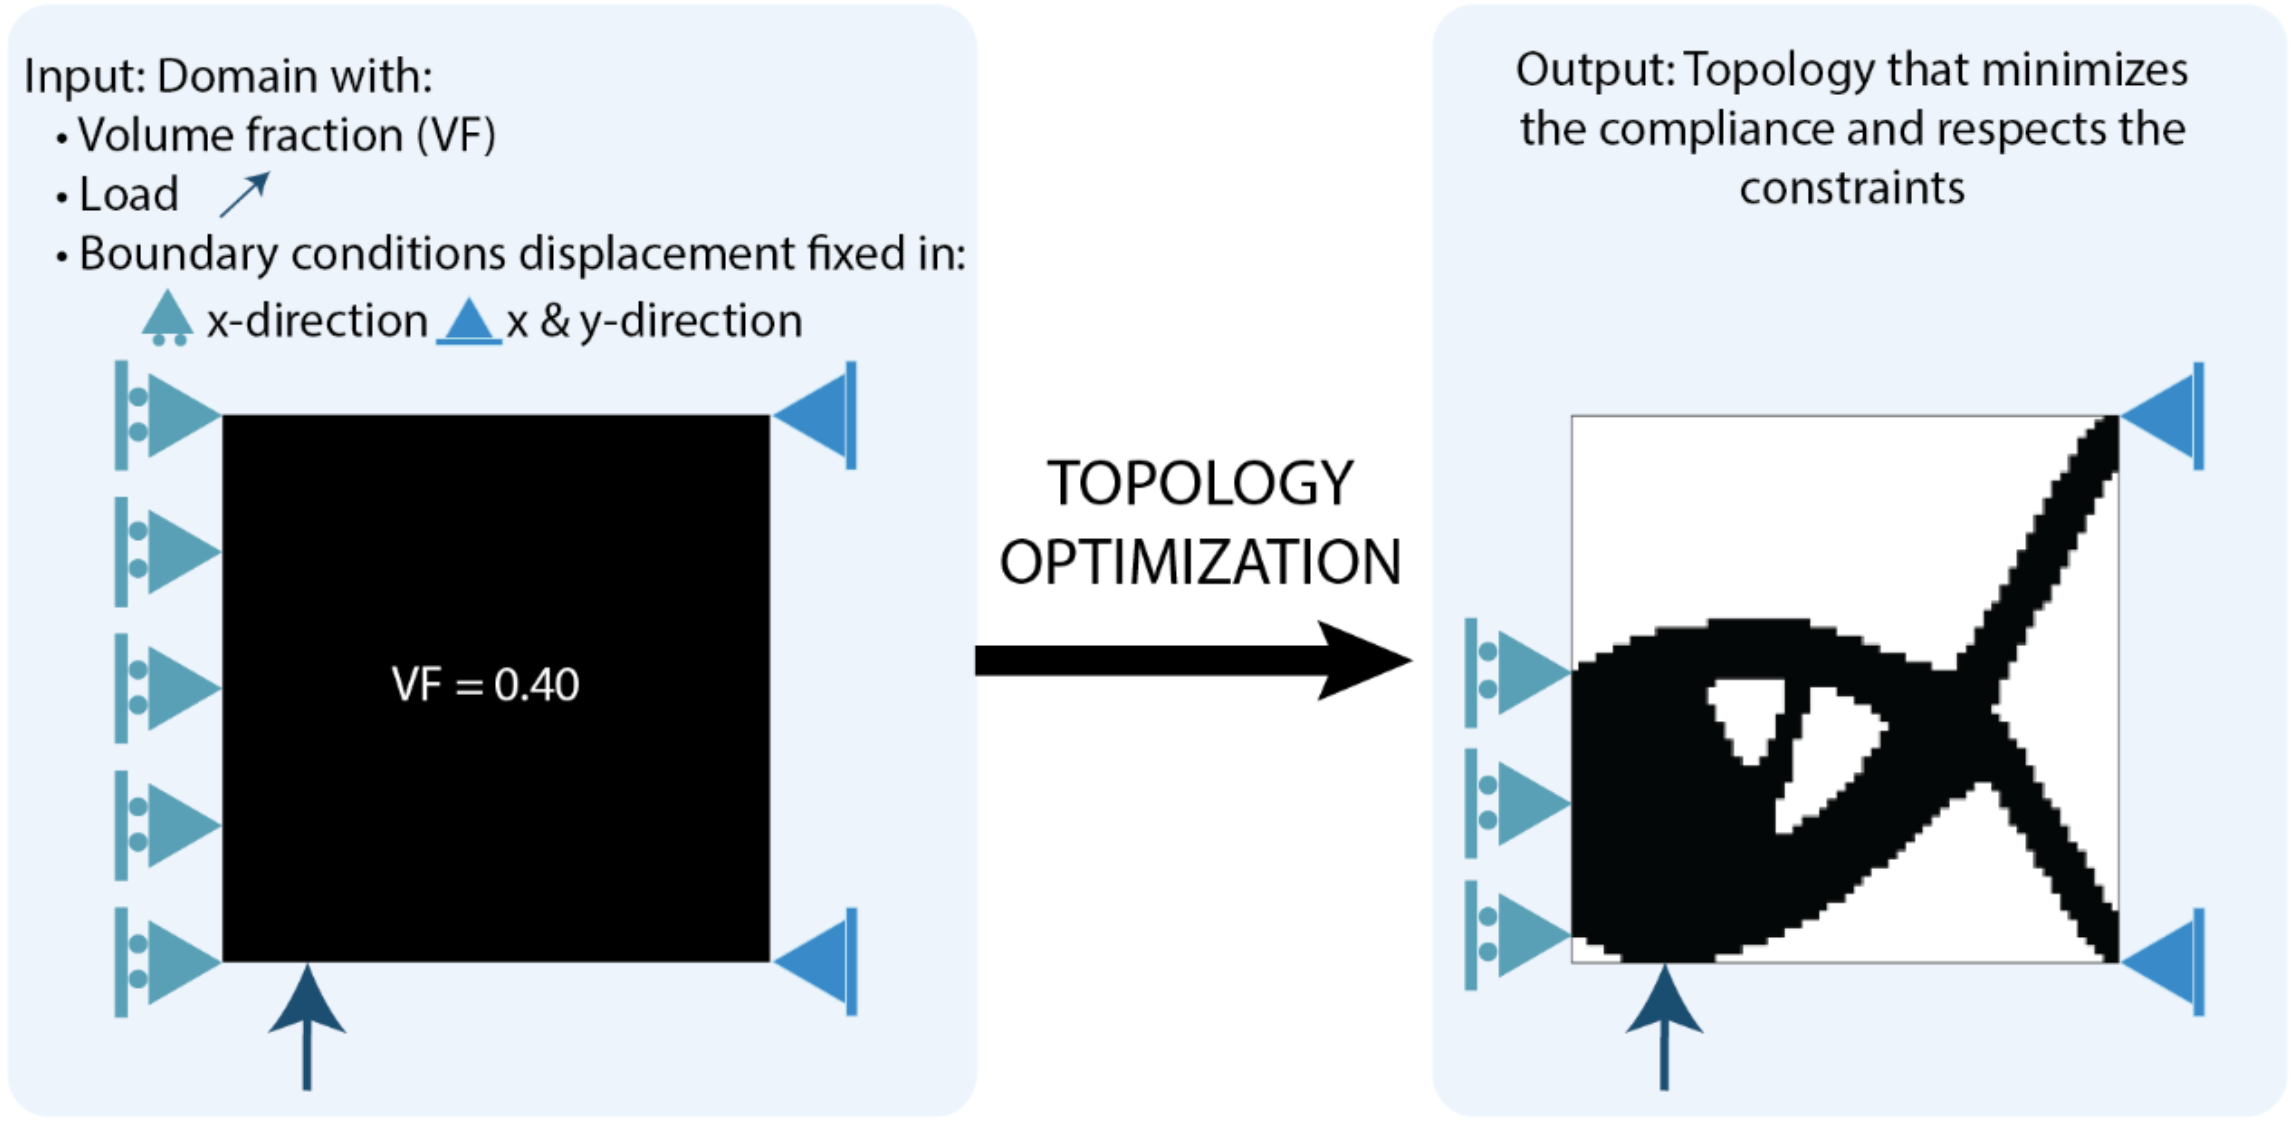

source: "Diffusion Models Beat GANs on Topology Optimization," Maze & Ahmed, 2023

### **The Task**
In this challenge problem, I reconstructed corrupted topologies for which portions of the structure have been deleted, as shown below.

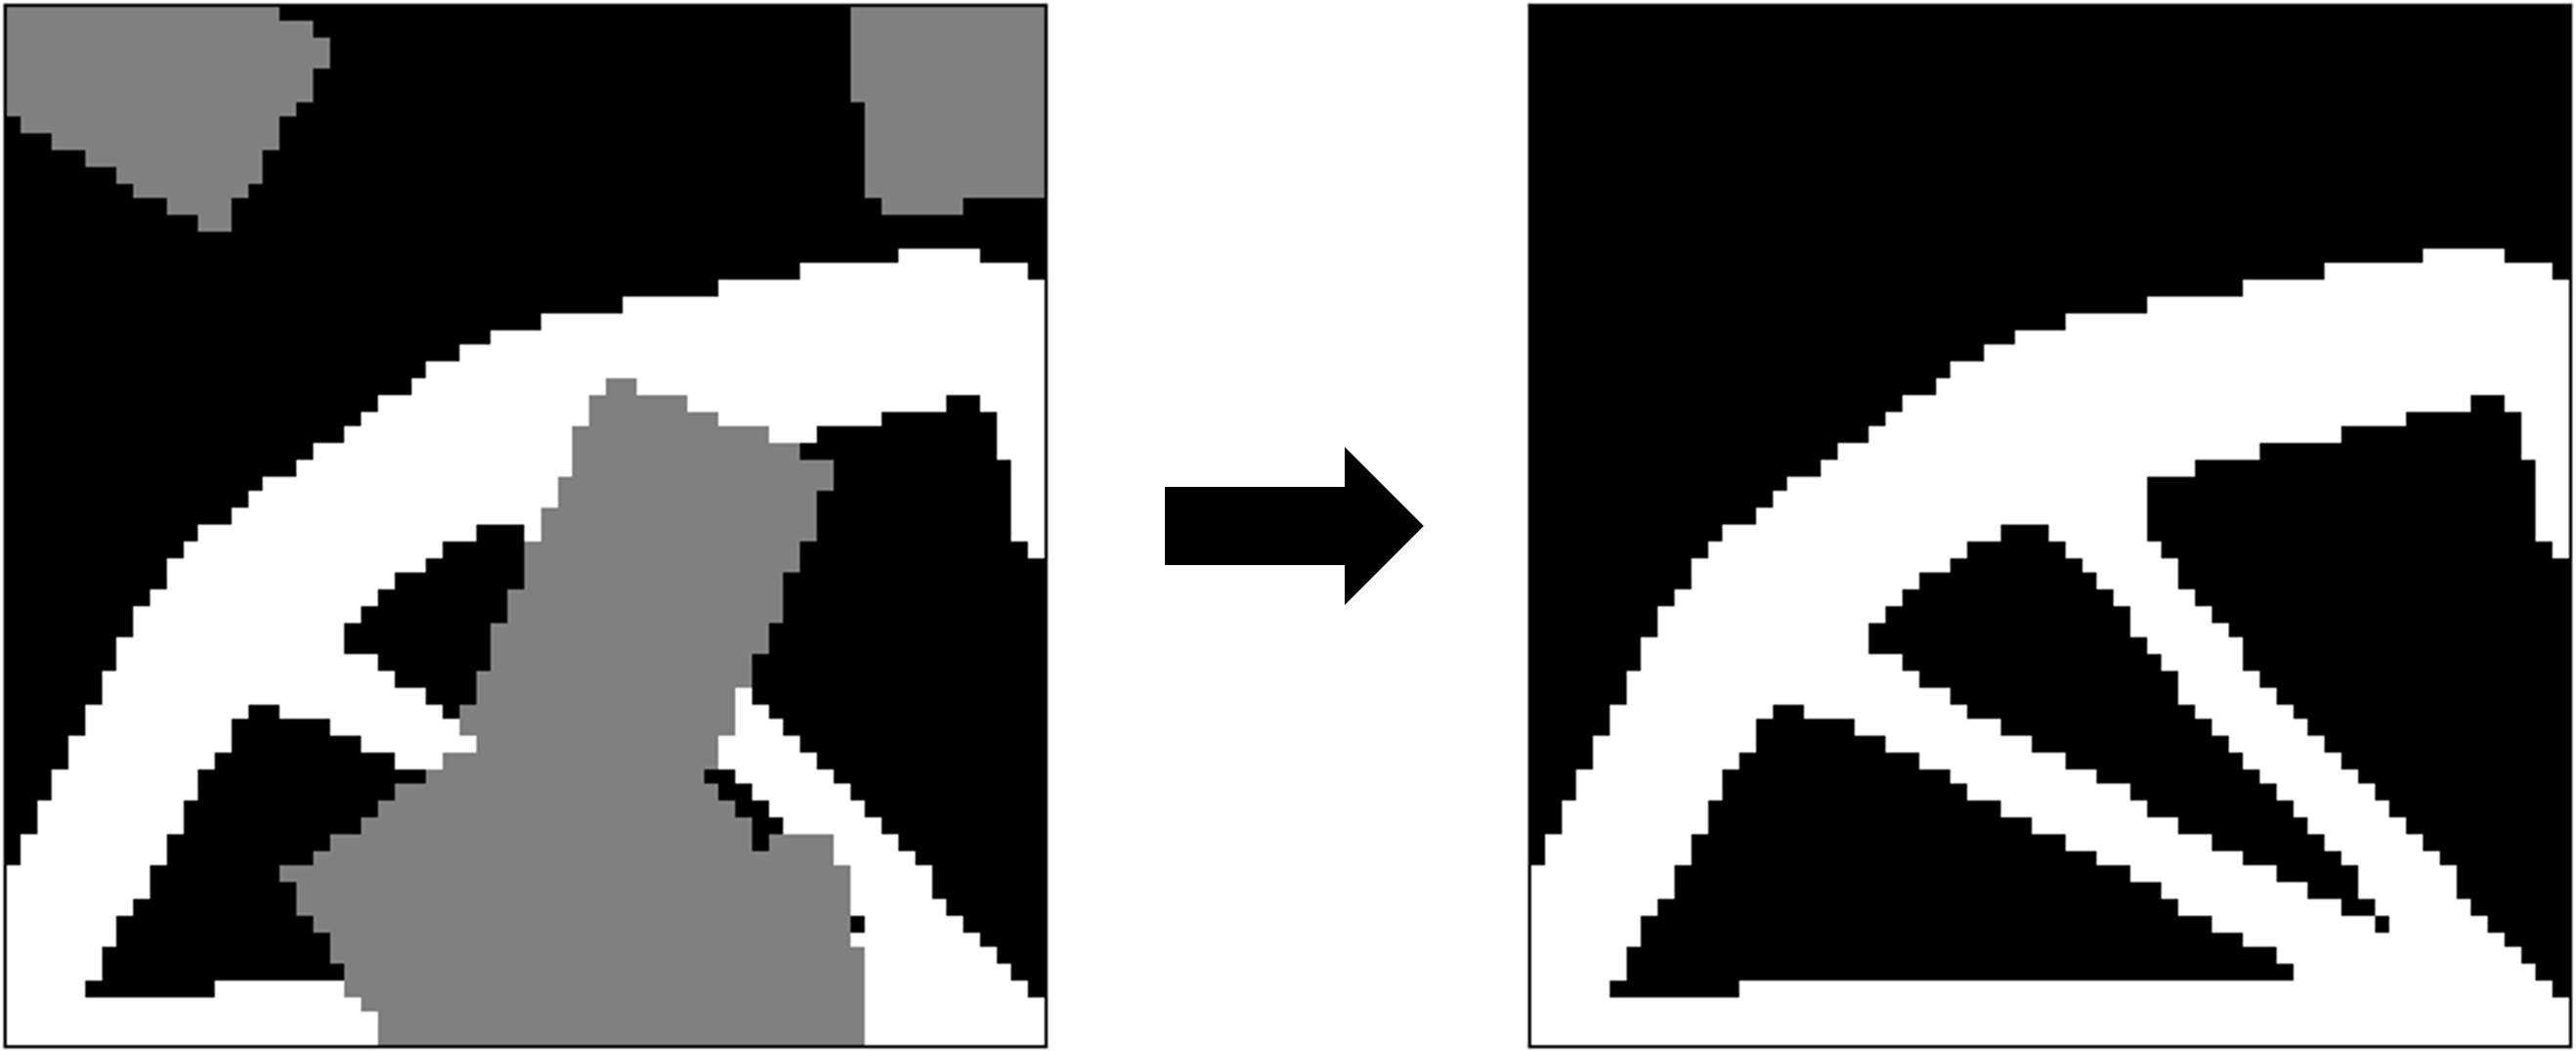


**The Dataset:**

We provide a dataset of 12,000 (uncorrupted) 64x64 topologies optimized for compliance minimization under a variety of loads, support cases, and material budgets. In these problems, 5 types of conditioning information are given, over which the material placement has been optimized. We'll refer to these simply as the 'constraints.'


*   Horizontal boundary conditions
*   Vertical boundary conditions
*   Horizontal loads
*   Vertical loads
*   Volume fraction


In [ ]:
topologies = np.load("topologies_train.npy")
print(topologies.shape)

(12000, 64, 64)


<Figure size 640x480 with 0 Axes>

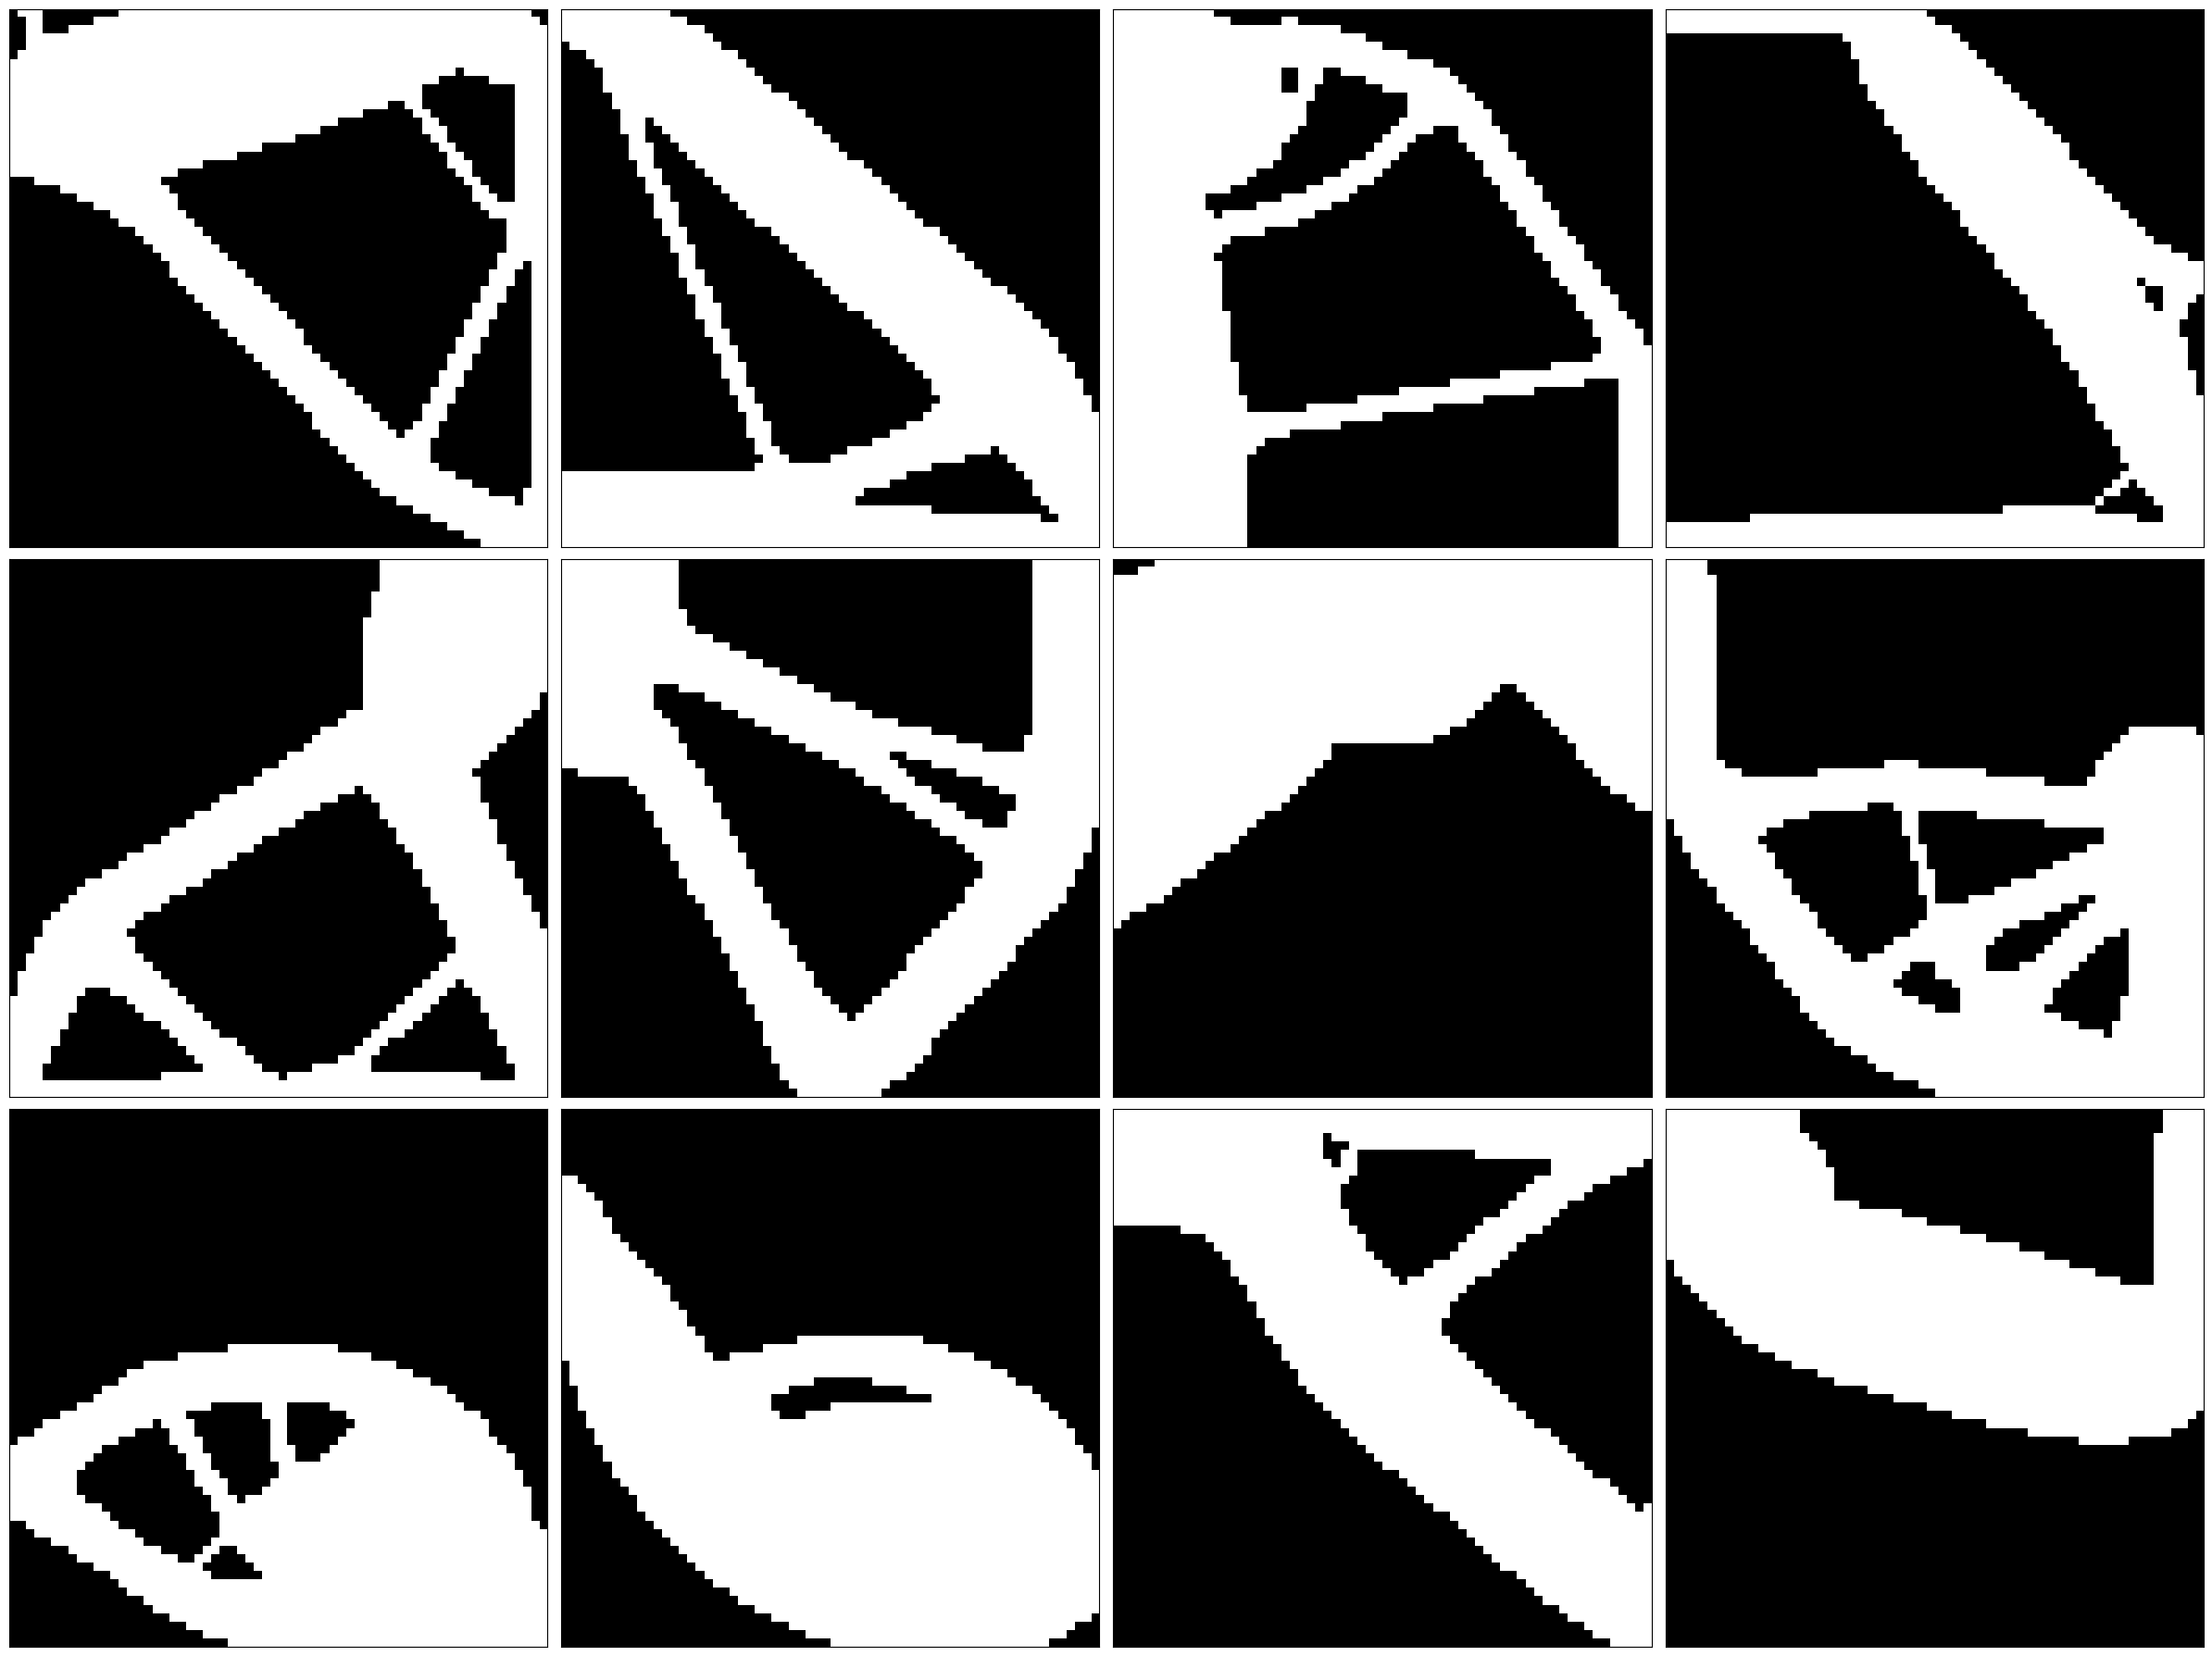

In [ ]:
random_indices = np.random.choice(range(len(topologies)), 12)
plot_n_topologies(topologies[random_indices])

In [ ]:
constraints = np.load("constraints_train.npy", allow_pickle=True)
print(len(constraints))
constraints[0]

12000


array([<64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 68 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 70 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       <64x64 sparse matrix of type '<class 'numpy.float64'>'
       	with 1 stored elements in Compressed Sparse Row format>,
       0.46000000000000013], dtype=object)

In [ ]:
print(constraints[0][0])

  (0, 0)	1.0
  (0, 63)	1.0
  (1, 0)	1.0
  (1, 63)	1.0
  (2, 63)	1.0
  (3, 63)	1.0
  (4, 63)	1.0
  (5, 63)	1.0
  (6, 63)	1.0
  (7, 63)	1.0
  (8, 63)	1.0
  (9, 63)	1.0
  (10, 63)	1.0
  (11, 63)	1.0
  (12, 63)	1.0
  (13, 63)	1.0
  (14, 63)	1.0
  (15, 63)	1.0
  (16, 63)	1.0
  (17, 63)	1.0
  (18, 63)	1.0
  (19, 63)	1.0
  (20, 63)	1.0
  (21, 63)	1.0
  (22, 63)	1.0
  :	:
  (41, 63)	1.0
  (42, 63)	1.0
  (43, 63)	1.0
  (44, 63)	1.0
  (45, 63)	1.0
  (46, 63)	1.0
  (47, 63)	1.0
  (48, 63)	1.0
  (49, 63)	1.0
  (50, 63)	1.0
  (51, 63)	1.0
  (52, 63)	1.0
  (53, 63)	1.0
  (54, 63)	1.0
  (55, 63)	1.0
  (56, 63)	1.0
  (57, 63)	1.0
  (58, 63)	1.0
  (59, 63)	1.0
  (60, 63)	1.0
  (61, 63)	1.0
  (62, 0)	1.0
  (62, 63)	1.0
  (63, 0)	1.0
  (63, 63)	1.0


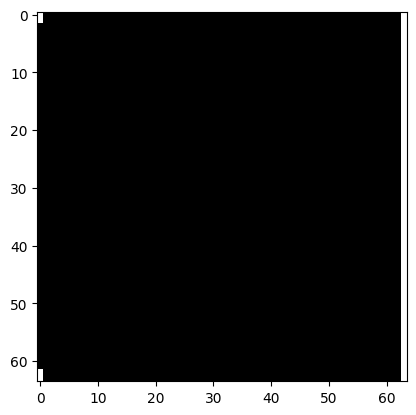

In [ ]:
plt.imshow(constraints[0][0].toarray(), cmap="gray")

In [ ]:
masked_topologies = []
for i in trange(len(topologies)):
    mask = random_n_masks(np.array((64,64)), 4, 7).astype(bool) #From the utils file - feel free to check it out
    topology = topologies[i]
    masked_topology = topology*(1-mask) + 0.5*(mask)
    masked_topologies.append(masked_topology)
masked_topologies = np.stack(masked_topologies)


100%|██████████| 12000/12000 [02:23<00:00, 83.44it/s]


<Figure size 640x480 with 0 Axes>

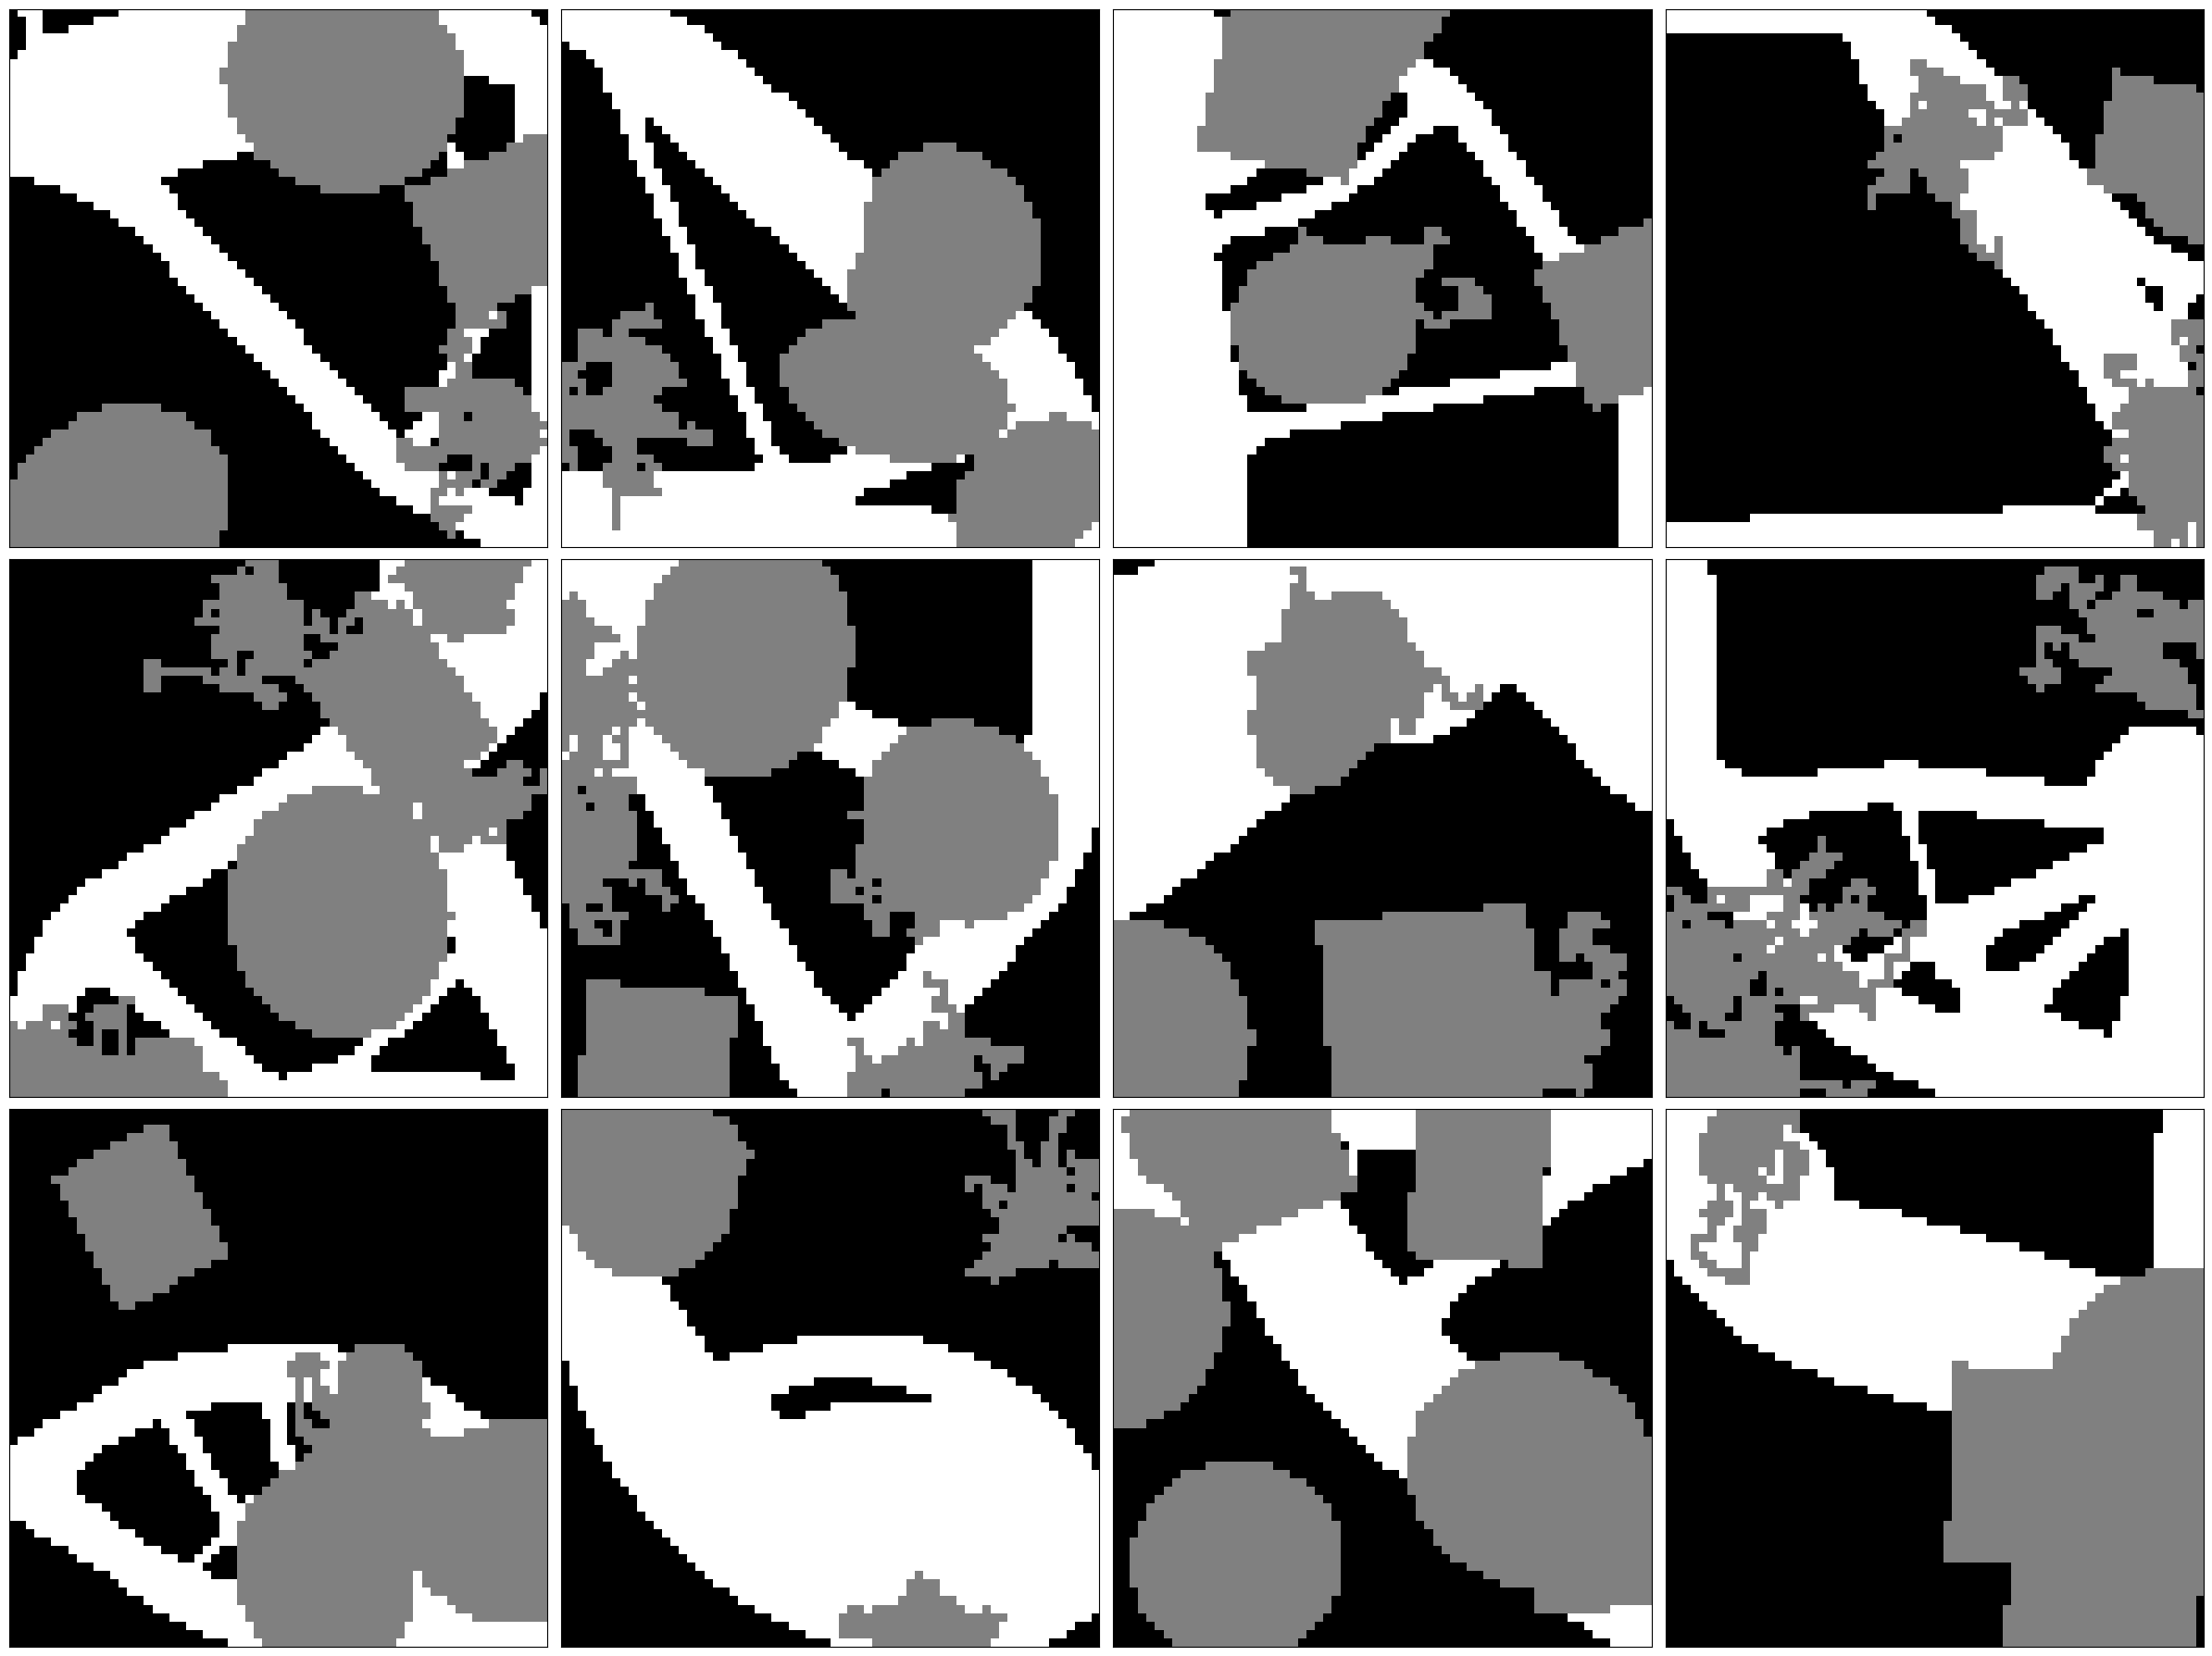

In [ ]:
plot_n_topologies(masked_topologies[random_indices])

In [ ]:
masked_constraints = mask_constraints(constraints) #From the utils file
print(masked_constraints[0])

[<64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 68 stored elements in Compressed Sparse Row format>
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 70 stored elements in Compressed Sparse Row format> None
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format> None]


Below isthe VAE model and a train loop function.

Note: This code does NOT make use of constraints.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class VAE(nn.Module): #Create VAE class inheriting from pytorch nn Module class VAE contains econder, a decoder, and methods for their interaction
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar): # allows VAE to backpropagate through a random process
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x_in)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.BatchNorm2d(hidden_size),
                    nn.ReLU()
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar

class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride, image_size):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for layer_num in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            next_h, next_w = self.calc_size_layer(layer_num, num_layers, kernel_size, stride, image_size) #Calculate the size of the output of the layer
            output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
            output_padding_w = next_w - kernel_size - stride*(w-1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)),
                    nn.BatchNorm2d(hidden_size),
                    nn.ReLU()
                )
            )
            h,w = next_h, next_w

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        next_h, next_w = image_size

        output_padding_h = next_h - kernel_size - stride*(h-1) #Calculate the output padding to ensure the output size is correct
        output_padding_w = next_w - kernel_size - stride*(w-1)
        #Final layer brings the image to the original size
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride),
                                        nn.ReplicationPad2d((0,output_padding_w,0, output_padding_h)))
    def calc_size_layer(self, layer_num, num_layers, kernel_size, stride, image_size):
        #Function to calculate the number of channels for a given layer
        h, w = image_size
        for _ in range(num_layers-layer_num-1):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h,w


    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x_out, mu, logvar):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x_out, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    return BCE + KLD

def train(epoch, data_in_tensor, data_out_tensor): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu/tpu is available

# convert masked_topoliges and topoliges from numpy arrays to pytorch tensors
data_in_tensor = torch.from_numpy(masked_topologies).float().to(device)
data_out_tensor = torch.from_numpy(topologies).float().to(device)

#expand dims of tensor in channel 1
data_in_tensor = data_in_tensor.unsqueeze(1)
data_out_tensor = data_out_tensor.unsqueeze(1)

In [ ]:
input_channels = 1
image_size = (64, 64)

latent_dim = 300
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 25
batch_size = 10

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Let's look at a model summary
from torchsummary import summary
print((input_channels, image_size[0], image_size[1]))
summary(model, input_size=(input_channels, image_size[0], image_size[1]))

(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
       BatchNorm2d-2           [-1, 64, 31, 31]             128
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
       BatchNorm2d-5           [-1, 64, 15, 15]             128
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 300]         941,100
           Linear-11                  [-1, 300]         941,100
          Encoder-12     [[-1, 300], [-1, 300]]               0
           Linear-13                 [-1, 3136]         943,936
  ConvTranspose2d-14       

In [ ]:
# Main loop
for epoch in range(1, num_epochs + 1):
    train(epoch, data_in_tensor, data_out_tensor)

Epoch: 1 	Training Loss: 1267.237


Epoch: 2 	Training Loss: 945.708


Epoch: 3 	Training Loss: 856.980


Epoch: 4 	Training Loss: 795.161


Epoch: 5 	Training Loss: 745.897


Epoch: 6 	Training Loss: 705.615


Epoch: 7 	Training Loss: 674.638


Epoch: 8 	Training Loss: 647.693


Epoch: 9 	Training Loss: 622.475


Epoch: 10 	Training Loss: 602.245


Epoch: 11 	Training Loss: 585.795


Epoch: 12 	Training Loss: 569.794


Epoch: 13 	Training Loss: 555.483


Epoch: 14 	Training Loss: 544.106


Epoch: 15 	Training Loss: 532.297


Epoch: 16 	Training Loss: 522.593


Epoch: 17 	Training Loss: 513.450


Epoch: 18 	Training Loss: 504.721


Epoch: 19 	Training Loss: 497.181


Epoch: 20 	Training Loss: 490.691


Epoch: 21 	Training Loss: 484.019


Epoch: 22 	Training Loss: 477.864


Epoch: 23 	Training Loss: 472.519


Epoch: 24 	Training Loss: 467.281


Epoch: 25 	Training Loss: 461.423


In [ ]:
# for testing different optimziers

def train(epoch, model, data_in_tensor, data_out_tensor, optimizer): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_in_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data_in = data_in_tensor[start_idx:end_idx] #Gather corresponding data
        data_out = data_out_tensor[start_idx:end_idx] #Gather corresponding data


        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar = model(data_in) #Call model
        loss = loss_function(recon_batch, data_out, mu, logvar) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_in_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

input_channels = 1
image_size = (64, 64)
latent_dim = 300
hidden_size = 64
num_layers = 3
kernel_size = 3
stride = 2
num_epochs = 25
batch_size = 10

# List of optimizers to try
optimizers_to_try = ['AdamW', 'Adam', 'NAdam', 'RMSprop']

for opt_name in optimizers_to_try:
    print(f"\nTraining with optimizer: {opt_name}")

    # Initialize the model
    model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device)

    # Select optimizer
    if opt_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
    elif opt_name == 'NAdam':
        optimizer = optim.NAdam(model.parameters(), lr=1e-3)
    elif opt_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

    # Model summary
    print((input_channels, image_size[0], image_size[1]))
    summary(model, input_size=(input_channels, image_size[0], image_size[1]))

    # Train the model
    for epoch in range(1, num_epochs + 1):
        train(epoch, model, data_in_tensor, data_out_tensor, optimizer)

    # Evaluate the model
    reconstructions = reconstruct_from_vae(model, masked_topologies_test, device)
    score = evaluate_score(masked_topologies_test, topologies_test, reconstructions)
    print(f"Accuracy with {opt_name}: {score:.5f}")



Training with optimizer: AdamW
(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
       BatchNorm2d-2           [-1, 64, 31, 31]             128
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
       BatchNorm2d-5           [-1, 64, 15, 15]             128
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 300]         941,100
           Linear-11                  [-1, 300]         941,100
          Encoder-12     [[-1, 300], [-1, 300]]               0
           Linear-13                 [-1, 3136]         943

Epoch: 1 	Training Loss: 1255.572


Epoch: 2 	Training Loss: 946.251


Epoch: 3 	Training Loss: 857.197


Epoch: 4 	Training Loss: 797.099


Epoch: 5 	Training Loss: 749.012


Epoch: 6 	Training Loss: 711.882


Epoch: 7 	Training Loss: 678.947


Epoch: 8 	Training Loss: 651.005


Epoch: 9 	Training Loss: 627.444


Epoch: 10 	Training Loss: 606.679


Epoch: 11 	Training Loss: 589.176


Epoch: 12 	Training Loss: 573.614


Epoch: 13 	Training Loss: 561.684


Epoch: 14 	Training Loss: 547.821


Epoch: 15 	Training Loss: 537.016


Epoch: 16 	Training Loss: 526.312


Epoch: 17 	Training Loss: 517.130


Epoch: 18 	Training Loss: 509.295


Epoch: 19 	Training Loss: 501.226


Epoch: 20 	Training Loss: 493.797


Epoch: 21 	Training Loss: 487.215


Epoch: 22 	Training Loss: 481.786


Epoch: 23 	Training Loss: 474.640


Epoch: 24 	Training Loss: 470.325


Epoch: 25 	Training Loss: 464.732
Accuracy with AdamW: 0.95332

Training with optimizer: Adam
(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
       BatchNorm2d-2           [-1, 64, 31, 31]             128
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
       BatchNorm2d-5           [-1, 64, 15, 15]             128
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 300]         941,100
           Linear-11                  [-1, 300]         941,100
          Encoder-12     [[-1, 300], [-1, 300]]              

Epoch: 1 	Training Loss: 1262.175


Epoch: 2 	Training Loss: 946.374


Epoch: 3 	Training Loss: 857.931


Epoch: 4 	Training Loss: 797.064


Epoch: 5 	Training Loss: 749.461


Epoch: 6 	Training Loss: 708.816


Epoch: 7 	Training Loss: 676.927


Epoch: 8 	Training Loss: 647.333


Epoch: 9 	Training Loss: 625.840


Epoch: 10 	Training Loss: 603.568


Epoch: 11 	Training Loss: 586.086


Epoch: 12 	Training Loss: 570.028


Epoch: 13 	Training Loss: 558.623


Epoch: 14 	Training Loss: 544.776


Epoch: 15 	Training Loss: 534.405


Epoch: 16 	Training Loss: 523.650


Epoch: 17 	Training Loss: 514.830


Epoch: 18 	Training Loss: 508.063


Epoch: 19 	Training Loss: 499.731


Epoch: 20 	Training Loss: 492.265


Epoch: 21 	Training Loss: 486.142


Epoch: 22 	Training Loss: 480.447


Epoch: 23 	Training Loss: 475.226


Epoch: 24 	Training Loss: 468.748


Epoch: 25 	Training Loss: 463.127
Accuracy with Adam: 0.95255

Training with optimizer: NAdam
(1, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
       BatchNorm2d-2           [-1, 64, 31, 31]             128
              ReLU-3           [-1, 64, 31, 31]               0
            Conv2d-4           [-1, 64, 15, 15]          36,928
       BatchNorm2d-5           [-1, 64, 15, 15]             128
              ReLU-6           [-1, 64, 15, 15]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
           Linear-10                  [-1, 300]         941,100
           Linear-11                  [-1, 300]         941,100
          Encoder-12     [[-1, 300], [-1, 300]]              

Epoch: 1 	Training Loss: 1251.917


Epoch: 2 	Training Loss: 931.175


Epoch: 3 	Training Loss: 844.011


Epoch: 4 	Training Loss: 784.550


Epoch: 5 	Training Loss: 737.250


Epoch: 6 	Training Loss: 699.291


Epoch: 7 	Training Loss: 667.537


Epoch 008:  51%|█████     | 613/1200 [01:04<00:56, 10.31it/s, training_loss=6001.139]

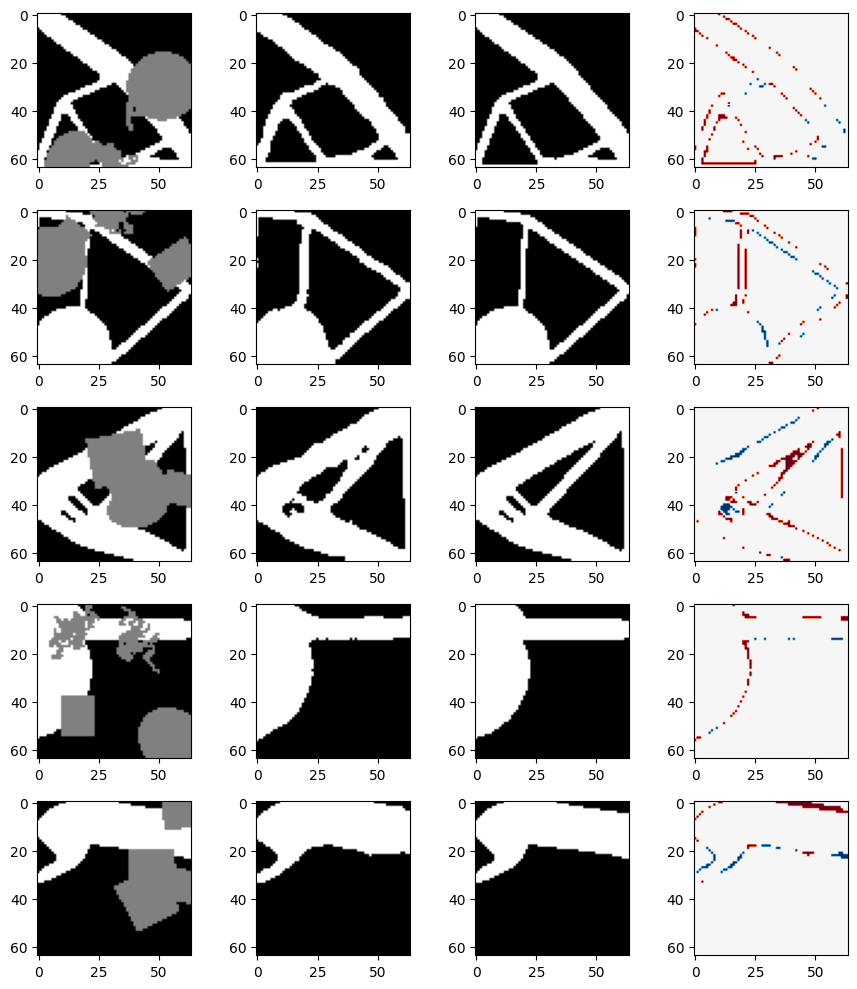

In [ ]:
def reconstruct_from_vae(model, masked_topologies, device='cpu'):
    with torch.no_grad():
        data_in = torch.from_numpy(masked_topologies).float()
        data_in = data_in.unsqueeze(1).to(device)
        samples = model(data_in)[0][:,0,:,:].to('cpu').numpy()
        samples = np.round(samples)
    return samples

def plot_reconstruction(originals, masked, reconstructions):
    # Function to plot reconstructed city grids alongside originals
    n = len(originals)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(9, 2*n))
    for i in range(n): # Loop over the grids
        axes[i,0].imshow(masked[i], cmap = "gray") # Plot masked on the left
        axes[i,1].imshow(reconstructions[i], cmap = "gray") # Plot reconstruction on the left
        axes[i,2].imshow(originals[i], cmap = "gray") #Plot originals on the right
        axes[i,3].imshow(originals[i]-reconstructions[i], cmap = "RdBu", vmin=-1, vmax=1) #Plot error on the right
    fig.tight_layout()
    plt.show()

originals = np.random.choice(np.arange(len(masked_topologies)), size=5, replace=False) #Select 5 random indices
reconstructions = reconstruct_from_vae(model, masked_topologies[originals], device) #Reconstruct
plot_reconstruction(topologies[originals], masked_topologies[originals], reconstructions) #Compare

In [ ]:
topologies_test = np.load("topologies_test.npy")
masked_topologies_test = np.load("masked_topologies_test.npy")
reconstructions_test = reconstruct_from_vae(model, masked_topologies_test, device) #Reconstruct

In [ ]:
def evaluate_score(masked_topologies, original_topologies, reconstructed_topologies):
    masks = masked_topologies==0.5 #Identify the masked regions
    correct = reconstructed_topologies==original_topologies #Identify all correctly predicted pixels
    correct_in_mask = np.logical_and(correct, masks) # Identify all correctly predicted pixels within masked regions
    accuracy_fractions = np.sum(correct_in_mask, axis=(1,2))/np.sum(masks, axis=(1,2)) #(correct & mask)/#(mask) for each topology individually
    average_accuracy_fraction = np.mean(accuracy_fractions) #Average of these ratios across test set
    return average_accuracy_fraction
score = evaluate_score(masked_topologies_test, topologies_test, reconstructions_test)
print(f"Final Accuracy: {score:.5f}")

Final Accuracy: 0.95477


<Figure size 640x480 with 0 Axes>

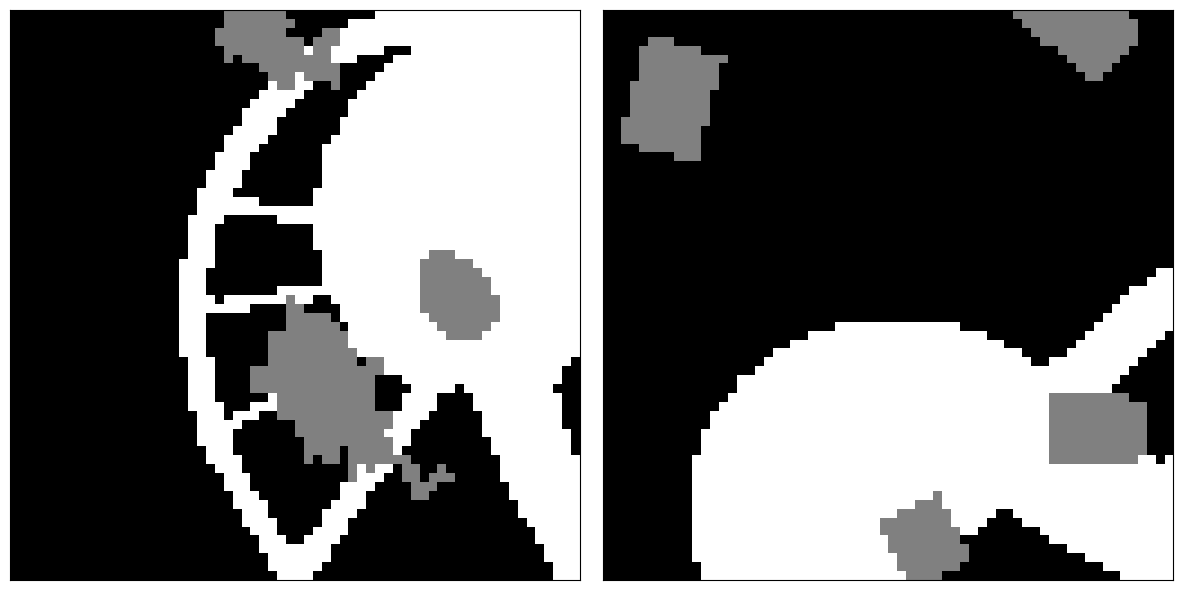

In [ ]:
masked_topologies_submission = np.load("masked_topologies_submission.npy")
random_indices = np.random.choice(range(len(masked_topologies_submission)), 2)
plot_n_topologies(masked_topologies_submission[random_indices])

In [ ]:
reconstructions_submission = reconstruct_from_vae(model, masked_topologies_submission, device) #Reconstruct
reconstructions_submission = np.round(reconstructions_submission).astype(bool)

<Figure size 640x480 with 0 Axes>

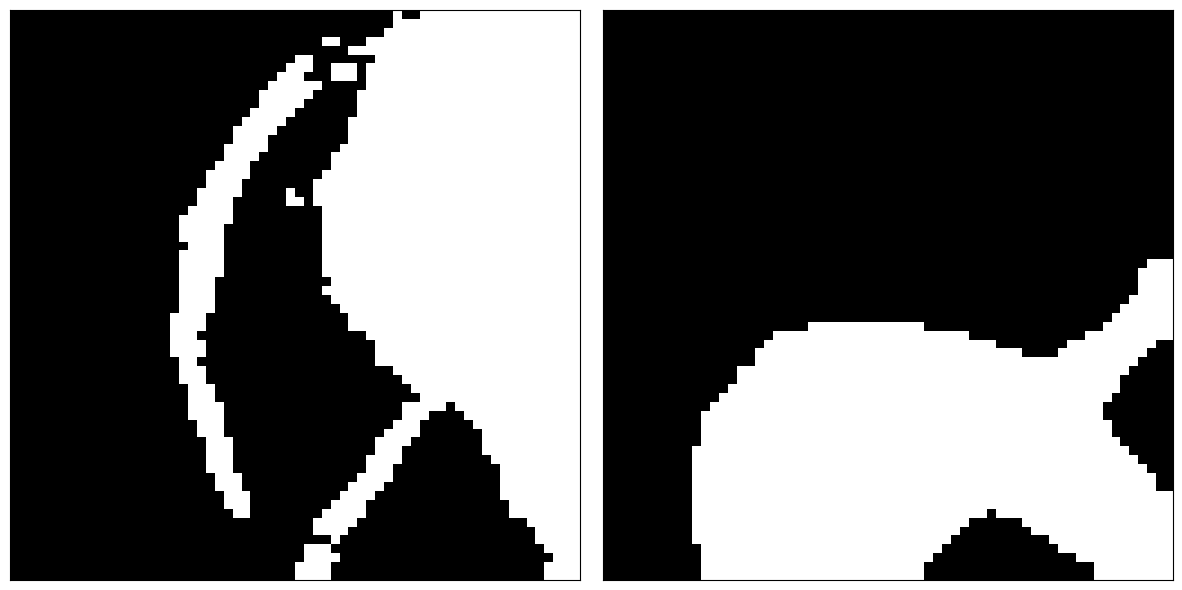

In [ ]:
plot_n_topologies(reconstructions_submission[random_indices])

In [ ]:
np.save("CP3_final_submission.npy", reconstructions_submission)